In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools

# Generate fHMM Data

We begin by generation fhmm type data using the generative modeling tools in hela.

In [27]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[3,2,2],
                                     n_gaussian_features =2,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)
factored_hidden_states.head()

,0,1,2
2020-08-01,0,0,1
2020-08-02,0,0,1
2020-08-03,0,0,1
2020-08-04,0,0,1
2020-08-05,0,0,1


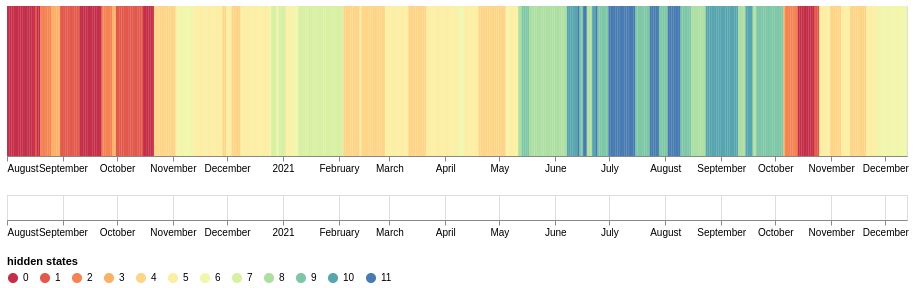

In [28]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

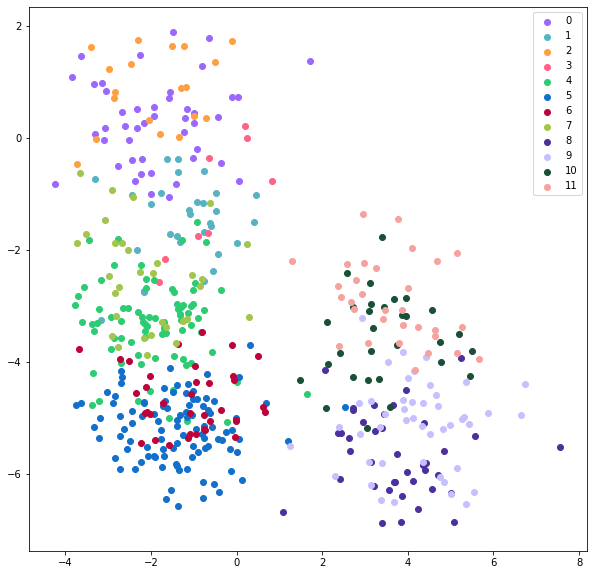

In [29]:
data = gen.generate_observations(factored_hidden_states)

plt.figure(figsize = (10,10))
feat = gen.gaussian_values.columns
for i in range(np.prod(gen.ns_hidden_states)):
    idx = np.where(flattened_hidden_states == i)
    df = np.array(data.loc[data.index[idx],feat])
    plt.scatter([d[0] for d in df],[d[1] for d in df], color = TU_COLORS[i],label = i)

plt.legend()
plt.show()

# Load fHMM Model Object

Instantiate model object.

In [30]:
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)
untrained_model = fhmm_config.to_model()
inf = untrained_model.load_inference_interface(data)

Carry out model training using gibbs sampling.

In [31]:
alg = untrained_model.load_learning_interface()
model = alg.run(data = data, 
                 method = 'gibbs', 
                 training_iterations = 2, # Rounds of model updates to carry out.
                 gibbs_iterations = 10, # Rounds of gibbs sampling for each round of statistics. 
                 burn_down_period = 10) # Rounbs of sampling to carry out before gathering statistics.

To check that the model is improving with each round of learning we will compute the complete data likelihood of the "flattened" hmm for each model result gathered during training.

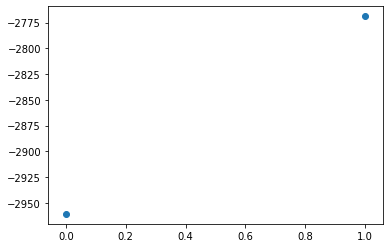

In [32]:
likelihood = []
for m in alg.model_results:
    spec = m.factored_hmm_to_discrete_hmm()
    hmm_config = hmm.DiscreteHMMConfiguration.from_spec(spec)
    hmm_model = hmm_config.to_model()
    hmm_inf = hmm_model.load_inference_interface()
    log_prob = hmm_inf.predict_hidden_state_log_probability(data)
    likelihood.append(logsumexp(hmm_inf._compute_forward_probabilities(log_prob)[-1]))
    
plt.scatter([t for t in range(len(likelihood))], likelihood)

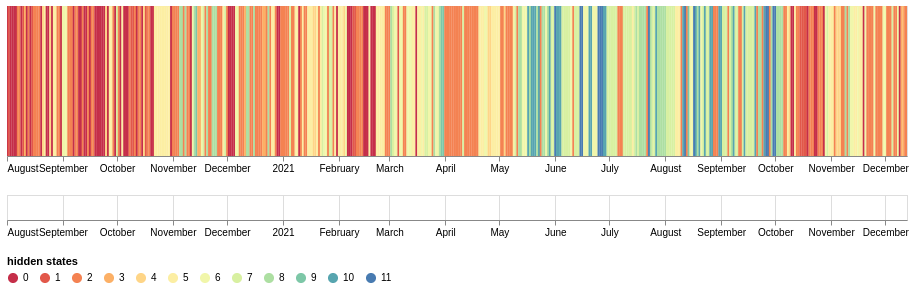

In [33]:
new_factored_hidden_states =  alg.sufficient_statistics[-1]['hidden_state_vector_df']
new_flattened_hidden_states = gen.flatten_hidden_state_sequence(new_factored_hidden_states)
hmmplot.draw_states(new_flattened_hidden_states, hide_brush=False)

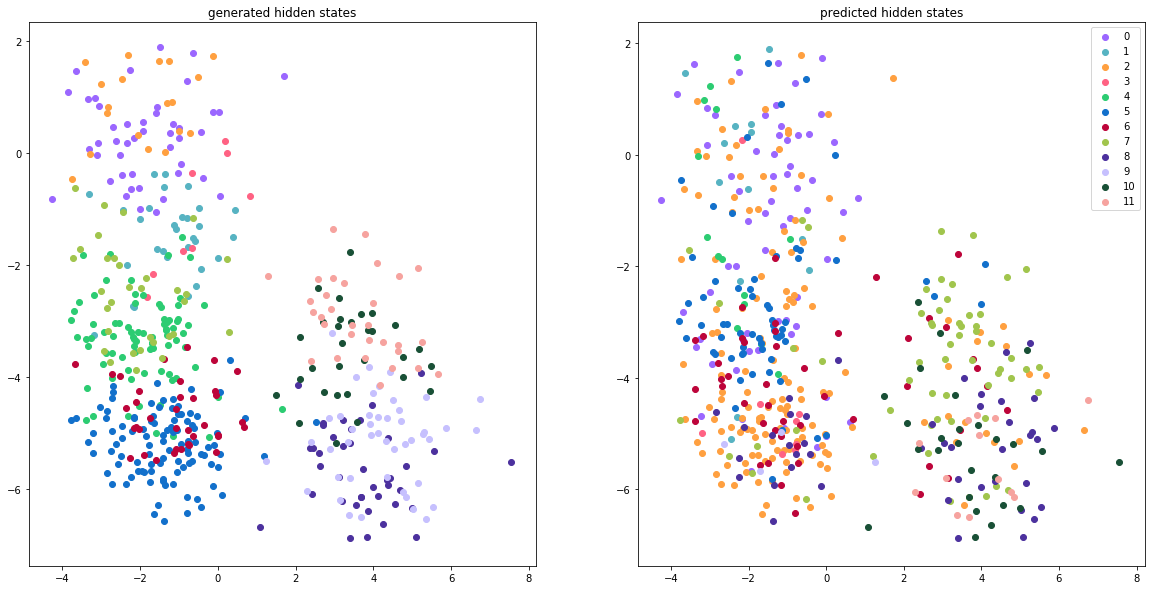

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))

feat = gen.gaussian_values.columns
for i in range(np.prod(gen.ns_hidden_states)):
    idx = np.where(flattened_hidden_states == i)
    df = np.array(data.loc[data.index[idx],feat])
    ax1.scatter([d[0] for d in df],[d[1] for d in df], color = TU_COLORS[i],label = i)
    ax1.set_title("generated hidden states")
    
for i in range(np.prod(gen.ns_hidden_states)):
    idx = np.where(new_flattened_hidden_states == i)
    df = np.array(data.loc[data.index[idx],feat])
    ax2.scatter([d[0] for d in df],[d[1] for d in df], color = TU_COLORS[i],label = i)
    ax2.set_title("predicted hidden states")


plt.legend()
plt.show()